#### Q.1) Import necessary libraries

In [699]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import copy
import datetime

In [634]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


#### Q.2) Load the given data

In [635]:
df=pd.read_csv('/home/agcl/Downloads/rnn_dataset.csv')

In [636]:
df

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


In [637]:
print(df.shape[0])

143206


<AxesSubplot:xlabel='Datetime'>

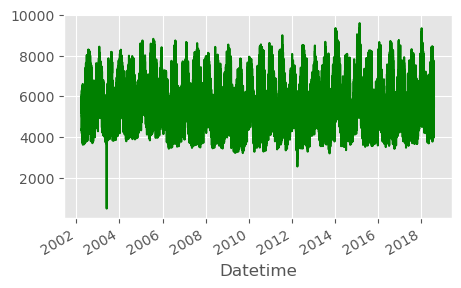

In [638]:
# Convert the 'Datetime' column to a datetime data type
df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True)

# Sort the DataFrame by the 'Datetime' column in ascending order
df = df.sort_values('Datetime')

# Set the 'Datetime' column as the index of the DataFrame
df.set_index('Datetime', inplace=True)

# Plot the time-series data of the 'PJMW_MW' column
df['PJMW_MW'].plot(c='g', figsize=(5, 3))

In [639]:
df

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [640]:
df=df.rename(columns={'PJMW_MW':'values'})
df

,values
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0
...,...
2018-08-02 20:00:00,6545.0
2018-08-02 21:00:00,6496.0
2018-08-02 22:00:00,6325.0


In [641]:
data=np.array(df)
data

array([[4374.],
       [4306.],
       [4322.],
       ...,
       [6325.],
       [5892.],
       [5489.]])

In [642]:
def prepare_data(data,n_features):
    '''Here, this function generates time-lagged observations of data and prepares dependent 
    and independent features by shifting the given data.'''
    y=[]
    for i in range(len(data)-100):
        y.append(data[i+100])
    x=np.empty((((n_features,len(y)))))
    for i in range(len(y)):
        x[:,i]=data[i:100+i].reshape(n_features,)
        
    return x,y

In [643]:
x,y=prepare_data(data,100)
print(len(y))
x=x.T

143106


In [644]:
x=x[:,::-1]
print(x.shape)
print(x)

(143106, 100)
[[5062. 5027. 5045. ... 4322. 4306. 4374.]
 [5172. 5062. 5027. ... 4359. 4322. 4306.]
 [5516. 5172. 5062. ... 4436. 4359. 4322.]
 ...
 [6496. 6545. 6693. ... 6454. 6632. 6688.]
 [6325. 6496. 6545. ... 6257. 6454. 6632.]
 [5892. 6325. 6496. ... 6034. 6257. 6454.]]


In [645]:
'''Here,each column of x contains 100 features or we can say that the x matrix is of the form (n,m) where n is the 
number of features(100) and n is the number of features(here,100) '''

'Here,each column of x contains 100 features or we can say that the x matrix is of the form (n,m) where n is the \nnumber of features(100) and n is the number of features(here,100) '

In [646]:
def gen_features(data,feature_dim):
    new_df = pd.DataFrame()
    # create columns for the previous 100 values as features
    for i in range(1,feature_dim+1):
        new_df['feature_' + str(i)] = df['values'].shift(i)

    # add the current value as the label
    new_df['label'] = df['values']

    # drop the first 100 rows since they don't have enough previous values to create features
    new_df.dropna(inplace=True)

    # reset the index of the new dataframe
    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [647]:
feature_dim=100
data_final=gen_features(df,feature_dim)
data_final

/tmp/ipykernel_11324/2534720155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['label'] = df['values']


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,label
0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,5852.0,...,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0,4374.0,5172.0
1,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,6254.0,...,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,4306.0,5516.0
2,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,6245.0,...,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,4322.0,5962.0
3,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,6053.0,...,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,4359.0,6240.0
4,6240.0,5962.0,5516.0,5172.0,5062.0,5027.0,5045.0,5140.0,5266.0,5634.0,...,5637.0,5683.0,5783.0,5722.0,5616.0,5482.0,5180.0,4723.0,4436.0,6113.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143101,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,6152.0,6050.0,5775.0,...,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,6688.0,6566.0,6359.0,6545.0
143102,6545.0,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,6152.0,6050.0,...,4731.0,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,6688.0,6566.0,6496.0
143103,6496.0,6545.0,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,6152.0,...,4593.0,4731.0,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,6688.0,6325.0
143104,6325.0,6496.0,6545.0,6693.0,6758.0,6708.0,6627.0,6492.0,6425.0,6299.0,...,4416.0,4593.0,4731.0,5160.0,5612.0,6034.0,6257.0,6454.0,6632.0,5892.0


In [648]:
print(data_final.shape)

(143106, 101)


In [649]:
values=data_final.iloc[:,-1]

In [650]:
values

0         5172.0
1         5516.0
2         5962.0
3         6240.0
4         6113.0
           ...  
143101    6545.0
143102    6496.0
143103    6325.0
143104    5892.0
143105    5489.0
Name: label, Length: 143106, dtype: float64

In [651]:
values=np.array(values)

In [652]:
m=values.shape[0]
values=values.reshape(m,1)

In [653]:
values.shape

(143106, 1)

In [654]:
data_final = data_final.drop('label', axis=1)
data_final=np.array(data_final)

In [655]:
data_final=np.array(data_final)
data_final.shape

(143106, 100)

#### SPLITTING THE DATASET INTO TRAIN,TEST AND VALIDATION DATASETS

In [656]:
X_train,x_test,Y_train,y_test=train_test_split(data_final,values,test_size=0.15,shuffle=False)
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.15/0.85,shuffle=False)

In [657]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)
print(x_train)

(100174, 100)
(21466, 100)
(21466, 100)
(100174, 1)
(21466, 1)
(21466, 1)
[[5062. 5027. 5045. ... 4322. 4306. 4374.]
 [5172. 5062. 5027. ... 4359. 4322. 4306.]
 [5516. 5172. 5062. ... 4436. 4359. 4322.]
 ...
 [5221. 5651. 6082. ... 5757. 6144. 6130.]
 [4655. 5221. 5651. ... 5306. 5757. 6144.]
 [4318. 4655. 5221. ... 4815. 5306. 5757.]]


In [658]:
'''Normalising data'''
scaler=StandardScaler()
x_train_norm=scaler.fit_transform(x_train)
x_test_norm=scaler.transform(x_test)
x_val_norm=scaler.transform(x_val)
y_train_norm=scaler.fit_transform(y_train)
y_test_norm=scaler.transform(y_test)
y_val_norm=scaler.transform(y_val)

In [659]:
print(x_train_norm.shape)
print(x_test_norm.shape)
print(x_val_norm.shape)
print(y_train_norm.shape)
print(y_test_norm.shape)
print(y_val_norm.shape)
print(x_train_norm)

(100174, 100)
(21466, 100)
(21466, 100)
(100174, 1)
(21466, 1)
(21466, 1)
[[-0.56001169 -0.59651674 -0.57775445 ... -1.3325898  -1.34926606
  -1.27831737]
 [-0.44531811 -0.56002306 -0.59652269 ... -1.29399577 -1.33257685
  -1.34924599]
 [-0.08664    -0.44532866 -0.5600289  ... -1.21367846 -1.29398304
  -1.3325569 ]
 ...
 [-0.39422733  0.05411331  0.50350437 ...  0.16423276  0.5679075
   0.55330989]
 [-0.98437795 -0.39423752  0.05410943 ... -0.30619719  0.16423711
   0.56791284]
 [-1.33575738 -0.98439234 -0.39424283 ... -0.81835042 -0.30619013
   0.16424555]]


In [660]:
'''Initializing tensors'''
x_train_norm=torch.tensor(x_train_norm,dtype=torch.float)
x_test_norm=torch.tensor(x_test_norm,dtype=torch.float)
x_val_norm=torch.tensor(x_val_norm,dtype=torch.float)
y_train_norm=torch.tensor(y_train_norm,dtype=torch.float)
y_test_norm=torch.tensor(y_test_norm,dtype=torch.float)
y_val_norm=torch.tensor(y_val_norm,dtype=torch.float)
print(type(x_train_norm))

<class 'torch.Tensor'>


In [661]:
class RNN(nn.Module):
    '''This class defines a simple recurrent neural network model(vanilla/elman RNN) which is used here for the 
    prediction of above given univariate time-series data.
    input_dim: dimensionality of input tensor which is the size of the input vector at each time step(here,100)
    hidden_dim: dimensionality of the hidden state tensor which is the size of the hidden vector passed from one
    timestep to the next(ht-1)
    layer_dim: the number of RNN layers in the network.A layer contains a set of recurent cells that process the 
    input and hidden states to generate the outputs and new hidden states.
    '''
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fully_connected = nn.Linear(hidden_dim, output_dim)

        
    '''forward propagation'''
    def forward(self,x):
        '''takes tensor x as input and computes the forward propagation'''
        h0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim,device=x.device,requires_grad=True,dtype=torch.float)
        out,h_n=self.rnn(x,h0.detach())
        out=out[:,-1,:]
        out=self.fully_connected(out)
        return out
        
'''detach() is called to avoid the backprop to pass through it.out,ho are the 2 outputs obtained when forward 
propagation is called on rnn.
The dimension of out is (batch-size,sequence_length(input_dim),hidden_dim), which
basically contains the output at each timestep of the sequence.
The dimension of h_n is (layer-dim,batch_size,hidden_dim),which conains the final hidden state of rnn. This can 
be used as an initial state for another rnn instance to continue the sequence.
Note that the dimension of x is in the form (batch_size,input_dim) or (m,n)''' 
        
    

'detach() is called to avoid the backprop to pass through it.out,ho are the 2 outputs obtained when forward \npropagation is called on rnn.\nThe dimension of out is (batch-size,sequence_length(input_dim),hidden_dim), which\nbasically contains the output at each timestep of the sequence.\nThe dimension of h_n is (layer-dim,batch_size,hidden_dim),which conains the final hidden state of rnn. This can \nbe used as an initial state for another rnn instance to continue the sequence.\nNote that the dimension of x is in the form (batch_size,input_dim) or (m,n)'

In [662]:
def dataloader(x,y,batch_size):
    '''Assigning data to dataloader'''
    combined=TensorDataset(x,y)
    loader = DataLoader(combined, batch_size=batch_size, shuffle=False, drop_last=True)
    return loader

In [663]:
def training(model,learning_rate,epochs,weight_decay,batch_size,train_loader,val_loader):
    '''This function can be used to train the model and evaluate the performance of the model by finding the 
    train loss and validation losses. Here, Mean squared error function and r2-score is used as the
    evaluation criteria.'''
    
    criterion=nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    training_losses=[]
    validation_losses=[]
    r2_train=[]
    r2_val=[]
    for epoch in range(1,epochs+1):
        batch_losses=[]
        batch_r2=[]
        for x_batch,y_batch in train_loader:
            x_batch=x_batch.view(batch_size,-1,input_dim)
            '''here 1 is input size which is the no of features or dimensions in each time step of the input 
            sequence.Here,is is 1(univariate problem).So ,we have to convert the input to 3d Tensor as well, 
            since the h matrices will be 3-dimensional and there will be mismatch.Thats why a shape change is 
            given to the input data with -1. When we are giving a 1 dimension in the above tensor, it explicitly 
            sets the second dimension to1, while x.view(a,-1,b) automatically determines the size of the second 
            dimension based on the other specified dimensions and the total number of elements in the tensor.'''
            x_batch=x_batch.to(device)
            y_batch=y_batch.to(device)
            model.train()
            yhat_batch=model(x_batch)
            loss=criterion(y_batch,yhat_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            r2score_train=r2_score(y_batch.detach().cpu().numpy(),yhat_batch.detach().cpu().numpy())
            batch_r2.append(r2score_train)
            
        train_loss=np.mean(batch_losses)
        training_losses.append(train_loss)
        r2_score_train=np.mean(r2score_train)
        r2_train.append(r2_score_train)
        
        with torch.no_grad():
            batch_val_losses=[]
            batch_val_r2=[]
            for x_val,y_val in val_loader:
                x_val=x_val.view(batch_size,-1,input_dim)
                x_val=x_val.to(device)
                y_val=y_val.to(device)
                model.eval()
                yhat_val=model(x_val)
                val_loss=criterion(y_val,yhat_val)
                
                batch_val_losses.append(val_loss.item())
                r2score_val=r2_score(y_val.detach().cpu().numpy(),yhat_val.detach().cpu().numpy())
                batch_val_r2.append(r2score_train)
                
            validation_loss=np.mean(batch_val_losses)
            validation_losses.append(validation_loss)
            r2_score_val=np.mean(r2score_val)
            r2_val.append(r2_score_val)
        if (epoch <= epochs) | (epoch % 50 == 0):
            print(f"[{epoch}/{epochs}] Training loss: {train_loss:.4f}\t Validation loss: {validation_loss:.4f}")
            
    
    return training_losses,validation_losses,r2_train,r2_val
    

In [664]:
def plot_loss(train_loss,val_loss):
    plt.style.use('ggplot')
    plt.figure(figsize=(5,5))
    plt.plot(train_loss,label='Training Loss')
    plt.plot(val_loss,label='Validation loss')
    plt.legend()
    plt.title('Losses')
    plt.show()
    plt.close()
        

[1/30] Training loss: 0.0446	 Validation loss: 0.0460
[2/30] Training loss: 0.0268	 Validation loss: 0.0403
[3/30] Training loss: 0.0241	 Validation loss: 0.0361
[4/30] Training loss: 0.0221	 Validation loss: 0.0334
[5/30] Training loss: 0.0201	 Validation loss: 0.0317
[6/30] Training loss: 0.0186	 Validation loss: 0.0300
[7/30] Training loss: 0.0174	 Validation loss: 0.0286
[8/30] Training loss: 0.0164	 Validation loss: 0.0273
[9/30] Training loss: 0.0155	 Validation loss: 0.0259
[10/30] Training loss: 0.0149	 Validation loss: 0.0245
[11/30] Training loss: 0.0143	 Validation loss: 0.0231
[12/30] Training loss: 0.0138	 Validation loss: 0.0218
[13/30] Training loss: 0.0134	 Validation loss: 0.0207
[14/30] Training loss: 0.0131	 Validation loss: 0.0199
[15/30] Training loss: 0.0128	 Validation loss: 0.0193
[16/30] Training loss: 0.0125	 Validation loss: 0.0187
[17/30] Training loss: 0.0122	 Validation loss: 0.0183
[18/30] Training loss: 0.0119	 Validation loss: 0.0178
[19/30] Training lo

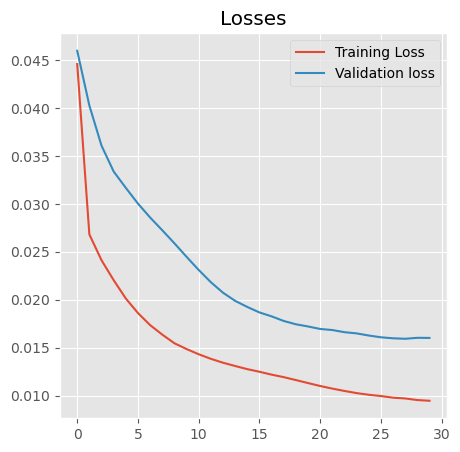

In [669]:
'''training the model'''
'''This model is flexible to change the number of hidden layers and number of neurons in the hidden layers also.
There is a fully connected layer and the number of neurons is given as one since we need a single prediction.
Based on the requirements, it can also be changed as well.
The data loader function can be used to'''
input_dim=x_train.shape[1]
output_dim=1
hidden_dim=64
layer_dim=1
batch_size=64
epochs=30
learning_rate=1e-3
weight_decay=1e-5
model=RNN(input_dim,hidden_dim,layer_dim,output_dim)
model.cuda() # when we are using the gpu through cuda,all the data,parameters and the model created should be 
#assigned to cuda by using this function call.
train_loader=dataloader(x_train_norm,y_train_norm,batch_size)
val_loader=dataloader(x_val_norm,y_val_norm,batch_size)
train_loss,validation_loss,r2_train,r2_val=training(model,learning_rate,epochs,weight_decay,
                                                batch_size,train_loader,val_loader)
plot_loss(train_loss,validation_loss)

In [670]:
def plot_r2score(r2_train,r2_val):
    plt.figure(figsize=(5,3))
    plt.plot(r2_train,label='R2-score(train)')
    plt.plot(r2_val,label='R2-score(validation)')
    plt.legend()
    plt.title('R2-SCORE')
    plt.show()
    plt.close()
        

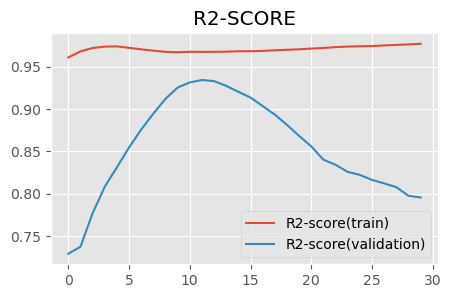

In [671]:
plot_r2score(r2_train,r2_val)

In [672]:
'''predictions on the test data using dataloader(not required,just for comparison)'''
test_loader=dataloader(x_test_norm,y_test_norm,batch_size=64)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
test_loss=[]
test_r2=[]
for x_test_batch,y_test_batch in test_loader:
    x_test_batch=x_test_batch.view(batch_size,-1,input_dim)
    x_test_batch=x_test_batch.to(device)
    y_test_batch=y_test_batch.to(device)
    model.eval()
    yhat_test=model(x_test_batch)
    testbatchloss=criterion(y_test_batch,yhat_test)
    test_loss.append(testbatchloss.item())
    r2score_test=r2_score(y_test_batch.detach().cpu().numpy(),yhat_test.detach().cpu().numpy())
    test_r2.append(r2score_test)
testing_loss=np.mean(test_loss)
test_r2=np.mean(test_r2)
print(f'The mean square error loss of given test data is {testing_loss}')
print(f'The R2-score of given test data is {test_r2}')
print(f'The root mean square error loss of given test data is {testing_loss**(1/2)}')
    

The mean square error loss of given test data is 0.013283788294656509
The R2-score of given test data is 0.9583536157475043
The root mean square error loss of given test data is 0.11525531785846807


In [673]:
x_test_norm.shape

torch.Size([21466, 100])

In [690]:
'''prediction on test data taking the whole test data at once'''
x_test_norm=x_test_norm.to(device)
y_test_norm=y_test_norm.to(device)
x_test_norm=x_test_norm.view(x_test_norm.size(0),-1,input_dim)
model.eval()
yp=model(x_test_norm)
testloss=criterion(y_test_norm,yp)
r2s_test=r2_score(y_test_norm.detach().cpu().numpy(),yp.detach().cpu().numpy())
mean_abs=mean_absolute_error(y_test_norm.detach().cpu().numpy(),yp.detach().cpu().numpy())
print(f'The mean square error loss of given test data is {testloss}')
print(f'The R2-score of given test data is {r2s_test}')
print(f'The mean absolute error loss of given test data is {mean_abs}')
print(f'The root mean square error loss of given test data is {testloss**(1/2)}')

The mean square error loss of given test data is 0.013276323676109314
The R2-score of given test data is 0.9874515927427554
The mean absolute error loss of given test data is 0.0864560678601265
The root mean square error loss of given test data is 0.11522293090820312


In [675]:
'''Below given the calculation of r2-score of test data after reverting the normalised data into original data'''
original_y_test = scaler.inverse_transform(y_test_norm.detach().cpu().numpy())
predicted_y_test=scaler.inverse_transform(yp.detach().cpu().numpy())
r2s_test_original=r2_score(original_y_test,predicted_y_test)
print(f'The R2-Score of un-normalised data is :{r2s_test_original}')

The R2-Score of un-normalised data is :0.9874515904554947


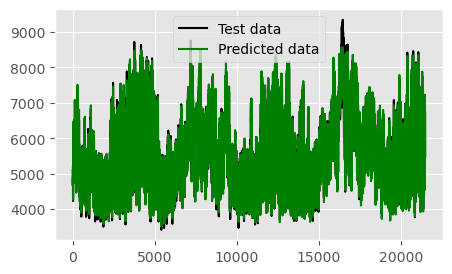

In [713]:
'''plotting the patterns of test and predicted data'''
plt.figure(figsize=(5,3))
plt.plot(original_y_test,label='Test data',color='black')
plt.plot(predicted_y_test,color='g',label='Predicted data')
plt.legend()
plt.show()

In [688]:
'''These are the actual and predicted values of test data'''
labels=np.concatenate((original_y_test,predicted_y_test),axis=1)
print(labels.shape)
labels=pd.DataFrame(labels)
labels=labels.rename(columns={0:'True',1:'Predicted'})
labels

(21466, 2)


,True,Predicted
0,4897.0,4838.552246
1,4765.0,4764.649902
2,4663.0,4676.861328
3,4709.0,4673.802246
4,4802.0,4824.572266
...,...,...
21461,6545.0,6546.600586
21462,6496.0,6432.345215
21463,6325.0,6359.208984
21464,5892.0,5935.203125
